In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from matplotlib.colors import ListedColormap

C:\Users\brend\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\brend\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\brend\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

Num GPUs Available:  1


In [3]:
def get_path(parts):
    out_path = ""
    for part in parts:
        out_path = out_path + f"{part}{os.path.sep}"

    out_path = out_path.rstrip(os.path.sep)
    return out_path

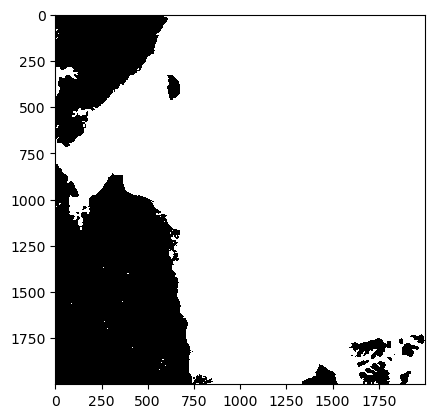

In [4]:
colors = ["#000000", "#FFFFFF"]
cmap = ListedColormap(colors, name="binary_map", N=len(colors))

array_2D = np.load(r"D:\IceDyno\IMS_images\2023\npy\ims2023001_1km_v1_grid1000.npy")
plt.imshow(array_2D, cmap=cmap)
plt.show()

In [5]:
array_2D.shape

(2000, 2000)

In [37]:
ims_dataset = []
root_dir = get_path(["D:\IceDyno", "IMS_images", "2023", "npy"])
file_list = glob.glob(get_path([root_dir, "*.npy"]))
for npy_file in file_list[:140]:
    ims_data_today = np.load(npy_file)
    ims_data_today_flattened = ims_data_today.flatten()
    ims_dataset.append(ims_data_today_flattened)
ims_dataset = np.array(ims_dataset)
ims_dataset.shape

(140, 4000000)

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = ims_dataset
# dataset = scaler.fit_transform(dataset)
dataset.shape, dataset

((140, 4000000),
 array([[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]], dtype=float32))

In [39]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]
print(len(train), len(test))

93 47


In [40]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [41]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(91, 1, 4000000) (91, 4000000)
(45, 1, 4000000) (45, 4000000)


In [42]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[2]))
print(trainX.shape, testX.shape)

(91, 1, 4000000) (45, 1, 4000000)


In [43]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, trainX.shape[2])))
model.add(Dense(trainX.shape[2]))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
91/91 - 5s - loss: 0.6872 - 5s/epoch - 59ms/step
Epoch 2/100
91/91 - 4s - loss: 0.5311 - 4s/epoch - 47ms/step
Epoch 3/100
91/91 - 4s - loss: 0.3879 - 4s/epoch - 46ms/step
Epoch 4/100
91/91 - 4s - loss: 0.2724 - 4s/epoch - 45ms/step
Epoch 5/100
91/91 - 4s - loss: 0.1848 - 4s/epoch - 43ms/step
Epoch 6/100
91/91 - 4s - loss: 0.1213 - 4s/epoch - 43ms/step
Epoch 7/100
91/91 - 4s - loss: 0.0769 - 4s/epoch - 43ms/step
Epoch 8/100
91/91 - 4s - loss: 0.0472 - 4s/epoch - 42ms/step
Epoch 9/100
91/91 - 4s - loss: 0.0280 - 4s/epoch - 43ms/step
Epoch 10/100
91/91 - 4s - loss: 0.0160 - 4s/epoch - 43ms/step
Epoch 11/100
91/91 - 4s - loss: 0.0089 - 4s/epoch - 43ms/step
Epoch 12/100
91/91 - 4s - loss: 0.0048 - 4s/epoch - 43ms/step
Epoch 13/100
91/91 - 4s - loss: 0.0025 - 4s/epoch - 43ms/step
Epoch 14/100
91/91 - 4s - loss: 0.0012 - 4s/epoch - 42ms/step
Epoch 15/100
91/91 - 4s - loss: 5.9743e-04 - 4s/epoch - 44ms/step
Epoch 16/100
91/91 - 4s - loss: 2.8000e-04 - 4s/epoch - 47ms/step
Epoch 17/

In [46]:
model.save("31424.h5")

InternalError: stream did not block host until done; was already in an error state

In [44]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
testPredict.shape, testPredict, testPredict[0]

InternalError: Graph execution error:

Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 4000000, 4, 1, 1, 32, 4] 
	 [[{{node CudnnRNN}}]]
	 [[sequential_2/lstm_2/PartitionedCall]] [Op:__inference_predict_function_43553]

In [ ]:
# We can reshape the output dataframe into the origional format
testPredict[0].reshape(2000, 2000)

In [ ]:
trainY.shape

In [ ]:
A = trainPredict[0]
B = testY[0]
mse = ((A - B) ** 2).mean()
mse

In [ ]:
plt.imshow(testPredict[0].reshape(2000, 2000), cmap="hot", interpolation="nearest")
plt.show()

In [ ]:
plt.imshow(testY[0].reshape(2000, 2000), cmap="hot", interpolation="nearest")
plt.show()

In [ ]:
plt.imshow(testPredict[0].reshape(2000, 2000), cmap="hot", interpolation="nearest")
plt.show()